In [ ]:
# import packages
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "5"

# Variables
model_name = 'meta-llama/Meta-Llama-3.1-8B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_10.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_10.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_last_token.pth'

In [ ]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [ ]:
def extract_hidden_states(texts, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    hidden_states = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        
        # 访问最后一个隐藏层的最后一个token的隐藏状态
        # hidden_states[-1]表示最后一个隐藏层，mean(dim=1)表示取所有头的均值
        last_layer_hidden_states = outputs.hidden_states[-1]
        last_token_hidden_states = last_layer_hidden_states[:, -1, :]  # -1表示最后一个token
        hidden_states.append(last_token_hidden_states.cpu().numpy())
    return np.vstack(hidden_states)

In [ ]:
# lode data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, y_non_infringement, infringement_outputs, y_infringement

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, f1_score

# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=2500, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')  # Initialize the best accuracy to negative infinity
    best_f1 = -float('inf')  # Initialize the best F1-score to negative infinity
    best_model_state = None  # Store the state of the best model
    best_epoch = 0  # Track the epoch with the best accuracy
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)  # Calculate F1-score
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            print(f"Test F1-score at Epoch {epoch + 1}: {f1:.4f}")
            
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            # Check if the current model is the best based on F1-score
            if f1 > best_f1:
                best_accuracy = accuracy
                best_f1 = f1
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with F1-score {best_f1:.4f} at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    # Load the best model state
    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    # Plot loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Best Model was saved at epoch {best_epoch} with F1-score {best_f1:.4f} and accuracy {best_accuracy * 100:.2f}%")
    return custom_mlp, losses, best_accuracy, best_f1


In [ ]:

tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, y_non_infringement, infringement_outputs, y_infringement = load_data(non_infringement_file, infringement_file)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


In [ ]:
print("Extracting hidden states for non_infringement texts...")
X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)

print("Extracting hidden states for infringement texts...")
X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)

In [ ]:
split_index_non_infringement = int(0.8 * len(X_non_infringement))
X_non_infringement_train = X_non_infringement[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement))
X_infringement_train = X_infringement[:split_index_infringement]
X_infringement_test = X_infringement[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")


Training Epochs:   8%|▊         | 201/2500 [00:02<00:28, 81.33it/s]

Epoch 190/2500, Loss: 0.0353
Test Accuracy at Epoch 190: 91.53%
Test F1-score at Epoch 190: 0.9296
Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118

Epoch 200/2500, Loss: 0.0353
Test Accuracy at Epoch 200: 91.53%
Test F1-score at Epoch 200: 0.9296
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118



Training Epochs:   9%|▉         | 226/2500 [00:02<00:22, 100.21it/s]

Epoch 210/2500, Loss: 0.0352
Test Accuracy at Epoch 210: 91.53%
Test F1-score at Epoch 210: 0.9296
Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118

Epoch 220/2500, Loss: 0.0352
Test Accuracy at Epoch 220: 91.53%
Test F1-score at Epoch 220: 0.9296
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118

Epoch 230/2500, Loss: 0.0352

Training Epochs:  10%|█         | 251/2500 [00:02<00:20, 109.87it/s]

Epoch 240/2500, Loss: 0.0351
Test Accuracy at Epoch 240: 91.53%
Test F1-score at Epoch 240: 0.9296
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118

Epoch 250/2500, Loss: 0.0351
Test Accuracy at Epoch 250: 91.53%
Test F1-score at Epoch 250: 0.9296
Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118

Epoch 260/2500, Loss: 0.0351

Training Epochs:  12%|█▏        | 289/2500 [00:03<00:19, 113.57it/s]

Epoch 270/2500, Loss: 0.0351
Test Accuracy at Epoch 270: 91.53%
Test F1-score at Epoch 270: 0.9296
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118

Epoch 280/2500, Loss: 0.0351
Test Accuracy at Epoch 280: 91.53%
Test F1-score at Epoch 280: 0.9296
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118

Epoch 290/2500, Loss: 0.0350

Training Epochs:  13%|█▎        | 315/2500 [00:03<00:18, 118.38it/s]

Epoch 300/2500, Loss: 0.0350
Test Accuracy at Epoch 300: 91.53%
Test F1-score at Epoch 300: 0.9296
Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118

Epoch 310/2500, Loss: 0.0350
Test Accuracy at Epoch 310: 91.53%
Test F1-score at Epoch 310: 0.9296
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118

Epoch 320/2500, Loss: 0.0350

Training Epochs:  14%|█▎        | 341/2500 [00:03<00:18, 119.42it/s]

Epoch 330/2500, Loss: 0.0350
Test Accuracy at Epoch 330: 91.53%
Test F1-score at Epoch 330: 0.9296
Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118

Epoch 340/2500, Loss: 0.0350
Test Accuracy at Epoch 340: 91.53%
Test F1-score at Epoch 340: 0.9296
Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118

Epoch 350/2500, Loss: 0.0350

Training Epochs:  15%|█▌        | 377/2500 [00:04<00:21, 99.97it/s] 

Epoch 360/2500, Loss: 0.0350
Test Accuracy at Epoch 360: 91.53%
Test F1-score at Epoch 360: 0.9296
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118

Epoch 370/2500, Loss: 0.0350
Test Accuracy at Epoch 370: 91.53%
Test F1-score at Epoch 370: 0.9296
Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118

Epoch 380/2500, Loss: 0.0350

Training Epochs:  16%|█▌        | 402/2500 [00:04<00:19, 107.21it/s]

Epoch 390/2500, Loss: 0.0350
Test Accuracy at Epoch 390: 91.53%
Test F1-score at Epoch 390: 0.9296
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118

Epoch 400/2500, Loss: 0.0349
Test Accuracy at Epoch 400: 91.53%
Test F1-score at Epoch 400: 0.9296
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118

Epoch 410/2500, Loss: 0.0349

Training Epochs:  18%|█▊        | 444/2500 [00:04<00:16, 124.05it/s]

Epoch 420/2500, Loss: 0.0349
Test Accuracy at Epoch 420: 91.53%
Test F1-score at Epoch 420: 0.9296
Classification Report at Epoch 420:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118

Epoch 430/2500, Loss: 0.0349
Test Accuracy at Epoch 430: 91.53%
Test F1-score at Epoch 430: 0.9296
Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118

Epoch 440/2500, Loss: 0.0349

Training Epochs:  19%|█▉        | 471/2500 [00:04<00:16, 126.21it/s]

Epoch 450/2500, Loss: 0.0349
Test Accuracy at Epoch 450: 91.53%
Test F1-score at Epoch 450: 0.9296
Classification Report at Epoch 450:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118

Epoch 460/2500, Loss: 0.0349
Test Accuracy at Epoch 460: 91.53%
Test F1-score at Epoch 460: 0.9296
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118

Epoch 470/2500, Loss: 0.0349

Training Epochs:  19%|█▉        | 485/2500 [00:04<00:15, 129.11it/s]

Epoch 480/2500, Loss: 0.0349
Test Accuracy at Epoch 480: 91.53%
Test F1-score at Epoch 480: 0.9296
Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118

Epoch 490/2500, Loss: 0.0349
Test Accuracy at Epoch 490: 91.53%
Test F1-score at Epoch 490: 0.9296
Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118



Training Epochs:  21%|██        | 525/2500 [00:05<00:17, 113.10it/s]

Epoch 500/2500, Loss: 0.0349
Test Accuracy at Epoch 500: 91.53%
Test F1-score at Epoch 500: 0.9296
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118

Epoch 510/2500, Loss: 0.0349
Test Accuracy at Epoch 510: 91.53%
Test F1-score at Epoch 510: 0.9296
Classification Report at Epoch 510:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118

Epoch 520/2500, Loss: 0.0349

Training Epochs:  22%|██▏       | 552/2500 [00:05<00:15, 122.81it/s]

Epoch 530/2500, Loss: 0.0349
Test Accuracy at Epoch 530: 91.53%
Test F1-score at Epoch 530: 0.9296
Classification Report at Epoch 530:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118

Epoch 540/2500, Loss: 0.0349
Test Accuracy at Epoch 540: 91.53%
Test F1-score at Epoch 540: 0.9296
Classification Report at Epoch 540:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118

Epoch 550/2500, Loss: 0.0349

Training Epochs:  23%|██▎       | 580/2500 [00:05<00:15, 125.94it/s]

Epoch 560/2500, Loss: 0.0349
Test Accuracy at Epoch 560: 91.53%
Test F1-score at Epoch 560: 0.9296
Classification Report at Epoch 560:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118

Epoch 570/2500, Loss: 0.0349
Test Accuracy at Epoch 570: 91.53%
Test F1-score at Epoch 570: 0.9296
Classification Report at Epoch 570:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118

Epoch 580/2500, Loss: 0.0349

Training Epochs:  24%|██▍       | 608/2500 [00:05<00:14, 128.42it/s]

Epoch 590/2500, Loss: 0.0349
Test Accuracy at Epoch 590: 91.53%
Test F1-score at Epoch 590: 0.9296
Classification Report at Epoch 590:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118

Epoch 600/2500, Loss: 0.0349
Test Accuracy at Epoch 600: 91.53%
Test F1-score at Epoch 600: 0.9296
Classification Report at Epoch 600:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118

Epoch 610/2500, Loss: 0.0349

Training Epochs:  25%|██▌       | 636/2500 [00:06<00:14, 131.45it/s]

Epoch 620/2500, Loss: 0.0349
Test Accuracy at Epoch 620: 91.53%
Test F1-score at Epoch 620: 0.9296
Classification Report at Epoch 620:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118

Epoch 630/2500, Loss: 0.0349
Test Accuracy at Epoch 630: 91.53%
Test F1-score at Epoch 630: 0.9296
Classification Report at Epoch 630:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118

Epoch 640/2500, Loss: 0.0349

Training Epochs:  27%|██▋       | 664/2500 [00:06<00:14, 130.39it/s]

Epoch 650/2500, Loss: 0.0349
Test Accuracy at Epoch 650: 91.53%
Test F1-score at Epoch 650: 0.9296
Classification Report at Epoch 650:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118

Epoch 660/2500, Loss: 0.0349
Test Accuracy at Epoch 660: 91.53%
Test F1-score at Epoch 660: 0.9296
Classification Report at Epoch 660:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118

Epoch 670/2500, Loss: 0.0349

Training Epochs:  28%|██▊       | 691/2500 [00:06<00:15, 114.06it/s]

Epoch 680/2500, Loss: 0.0349
Test Accuracy at Epoch 680: 91.53%
Test F1-score at Epoch 680: 0.9296
Classification Report at Epoch 680:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118

Epoch 690/2500, Loss: 0.0349
Test Accuracy at Epoch 690: 91.53%
Test F1-score at Epoch 690: 0.9296
Classification Report at Epoch 690:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118

Epoch 700/2500, Loss: 0.0349

Training Epochs:  28%|██▊       | 703/2500 [00:06<00:15, 114.36it/s]

Classification Report at Epoch 700:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118

Epoch 710/2500, Loss: 0.0349
Test Accuracy at Epoch 710: 91.53%
Test F1-score at Epoch 710: 0.9296
Classification Report at Epoch 710:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118



Training Epochs:  29%|██▉       | 734/2500 [00:07<00:22, 78.36it/s] 

Epoch 720/2500, Loss: 0.0349
Test Accuracy at Epoch 720: 91.53%
Test F1-score at Epoch 720: 0.9296
Classification Report at Epoch 720:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118

Epoch 730/2500, Loss: 0.0349
Test Accuracy at Epoch 730: 91.53%
Test F1-score at Epoch 730: 0.9296
Classification Report at Epoch 730:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118



Training Epochs:  30%|███       | 758/2500 [00:07<00:18, 92.43it/s]

Epoch 740/2500, Loss: 0.0349
Test Accuracy at Epoch 740: 91.53%
Test F1-score at Epoch 740: 0.9296
Classification Report at Epoch 740:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118

Epoch 750/2500, Loss: 0.0349
Test Accuracy at Epoch 750: 91.53%
Test F1-score at Epoch 750: 0.9296
Classification Report at Epoch 750:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118

Epoch 760/2500, Loss: 0.0349

Training Epochs:  31%|███▏      | 787/2500 [00:07<00:14, 115.14it/s]

Epoch 770/2500, Loss: 0.0349
Test Accuracy at Epoch 770: 91.53%
Test F1-score at Epoch 770: 0.9296
Classification Report at Epoch 770:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118

Epoch 780/2500, Loss: 0.0349
Test Accuracy at Epoch 780: 91.53%
Test F1-score at Epoch 780: 0.9296
Classification Report at Epoch 780:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118

Epoch 790/2500, Loss: 0.0349

Training Epochs:  33%|███▎      | 815/2500 [00:07<00:13, 124.73it/s]

Epoch 800/2500, Loss: 0.0349
Test Accuracy at Epoch 800: 91.53%
Test F1-score at Epoch 800: 0.9296
Classification Report at Epoch 800:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118

Epoch 810/2500, Loss: 0.0349
Test Accuracy at Epoch 810: 91.53%
Test F1-score at Epoch 810: 0.9296
Classification Report at Epoch 810:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118

Epoch 820/2500, Loss: 0.0349

Training Epochs:  34%|███▍      | 845/2500 [00:08<00:12, 130.91it/s]

Epoch 830/2500, Loss: 0.0349
Test Accuracy at Epoch 830: 91.53%
Test F1-score at Epoch 830: 0.9296
Classification Report at Epoch 830:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118

Epoch 840/2500, Loss: 0.0349
Test Accuracy at Epoch 840: 91.53%
Test F1-score at Epoch 840: 0.9296
Classification Report at Epoch 840:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118

Epoch 850/2500, Loss: 0.0349

Training Epochs:  35%|███▌      | 875/2500 [00:08<00:12, 135.21it/s]

Epoch 860/2500, Loss: 0.0349
Test Accuracy at Epoch 860: 91.53%
Test F1-score at Epoch 860: 0.9296
Classification Report at Epoch 860:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118

Epoch 870/2500, Loss: 0.0349
Test Accuracy at Epoch 870: 91.53%
Test F1-score at Epoch 870: 0.9296
Classification Report at Epoch 870:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118

Epoch 880/2500, Loss: 0.0349

Training Epochs:  36%|███▌      | 905/2500 [00:08<00:11, 138.12it/s]

Epoch 890/2500, Loss: 0.0349
Test Accuracy at Epoch 890: 91.53%
Test F1-score at Epoch 890: 0.9296
Classification Report at Epoch 890:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118

Epoch 900/2500, Loss: 0.0349
Test Accuracy at Epoch 900: 91.53%
Test F1-score at Epoch 900: 0.9296
Classification Report at Epoch 900:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118

Epoch 910/2500, Loss: 0.0349

Training Epochs:  37%|███▋      | 935/2500 [00:08<00:11, 138.31it/s]

Epoch 920/2500, Loss: 0.0349
Test Accuracy at Epoch 920: 91.53%
Test F1-score at Epoch 920: 0.9296
Classification Report at Epoch 920:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118

Epoch 930/2500, Loss: 0.0349
Test Accuracy at Epoch 930: 91.53%
Test F1-score at Epoch 930: 0.9296
Classification Report at Epoch 930:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118

Epoch 940/2500, Loss: 0.0349

Training Epochs:  39%|███▊      | 965/2500 [00:09<00:10, 140.46it/s]

Epoch 950/2500, Loss: 0.0349
Test Accuracy at Epoch 950: 91.53%
Test F1-score at Epoch 950: 0.9296
Classification Report at Epoch 950:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118

Epoch 960/2500, Loss: 26.8966
Test Accuracy at Epoch 960: 56.78%
Test F1-score at Epoch 960: 0.4632
Classification Report at Epoch 960:
                  precision    recall  f1-score   support

    infringement       0.49      0.92      0.64        49
non_infringement       0.85      0.32      0.46        69

        accuracy                           0.57       118
       macro avg       0.67      0.62      0.55       118
    weighted avg       0.70      0.57      0.54       118

Epoch 970/2500, Loss: 0.226

Training Epochs:  40%|███▉      | 995/2500 [00:09<00:10, 140.38it/s]

Epoch 980/2500, Loss: 0.2022
Test Accuracy at Epoch 980: 88.14%
Test F1-score at Epoch 980: 0.9041
Classification Report at Epoch 980:
                  precision    recall  f1-score   support

    infringement       0.93      0.78      0.84        49
non_infringement       0.86      0.96      0.90        69

        accuracy                           0.88       118
       macro avg       0.89      0.87      0.87       118
    weighted avg       0.89      0.88      0.88       118

Epoch 990/2500, Loss: 0.1456
Test Accuracy at Epoch 990: 89.83%
Test F1-score at Epoch 990: 0.9155
Classification Report at Epoch 990:
                  precision    recall  f1-score   support

    infringement       0.91      0.84      0.87        49
non_infringement       0.89      0.94      0.92        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 1000/2500, Loss: 0.118

Training Epochs:  41%|████      | 1025/2500 [00:09<00:10, 140.38it/s]

Epoch 1010/2500, Loss: 0.0943
Test Accuracy at Epoch 1010: 88.98%
Test F1-score at Epoch 1010: 0.9078
Classification Report at Epoch 1010:
                  precision    recall  f1-score   support

    infringement       0.89      0.84      0.86        49
non_infringement       0.89      0.93      0.91        69

        accuracy                           0.89       118
       macro avg       0.89      0.88      0.89       118
    weighted avg       0.89      0.89      0.89       118

Epoch 1020/2500, Loss: 0.0693
Test Accuracy at Epoch 1020: 89.83%
Test F1-score at Epoch 1020: 0.9143
Classification Report at Epoch 1020:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 1030/2500, Los

Training Epochs:  42%|████▏     | 1055/2500 [00:09<00:10, 141.27it/s]

Epoch 1040/2500, Loss: 0.0362
Test Accuracy at Epoch 1040: 89.83%
Test F1-score at Epoch 1040: 0.9143
Classification Report at Epoch 1040:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 1050/2500, Loss: 0.0355
Test Accuracy at Epoch 1050: 89.83%
Test F1-score at Epoch 1050: 0.9143
Classification Report at Epoch 1050:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 1060/2500, Los

Training Epochs:  43%|████▎     | 1085/2500 [00:09<00:10, 140.64it/s]

Epoch 1070/2500, Loss: 0.0361
Test Accuracy at Epoch 1070: 89.83%
Test F1-score at Epoch 1070: 0.9143
Classification Report at Epoch 1070:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 1080/2500, Loss: 0.0355
Test Accuracy at Epoch 1080: 89.83%
Test F1-score at Epoch 1080: 0.9143
Classification Report at Epoch 1080:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 1090/2500, Los

Training Epochs:  45%|████▍     | 1114/2500 [00:10<00:10, 137.65it/s]

Epoch 1100/2500, Loss: 0.0352
Test Accuracy at Epoch 1100: 89.83%
Test F1-score at Epoch 1100: 0.9143
Classification Report at Epoch 1100:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 1110/2500, Loss: 0.0353
Test Accuracy at Epoch 1110: 89.83%
Test F1-score at Epoch 1110: 0.9143
Classification Report at Epoch 1110:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 1120/2500, Los

Training Epochs:  46%|████▌     | 1152/2500 [00:10<00:13, 99.97it/s] 

Epoch 1130/2500, Loss: 0.0352
Test Accuracy at Epoch 1130: 89.83%
Test F1-score at Epoch 1130: 0.9143
Classification Report at Epoch 1130:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 1140/2500, Loss: 0.0352
Test Accuracy at Epoch 1140: 89.83%
Test F1-score at Epoch 1140: 0.9143
Classification Report at Epoch 1140:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 1150/2500, Los

Training Epochs:  47%|████▋     | 1176/2500 [00:10<00:12, 105.65it/s]

Epoch 1160/2500, Loss: 0.0352
Test Accuracy at Epoch 1160: 89.83%
Test F1-score at Epoch 1160: 0.9143
Classification Report at Epoch 1160:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 1170/2500, Loss: 0.0352
Test Accuracy at Epoch 1170: 89.83%
Test F1-score at Epoch 1170: 0.9143
Classification Report at Epoch 1170:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 1180/2500, Los

Training Epochs:  49%|████▊     | 1213/2500 [00:11<00:11, 113.35it/s]

Epoch 1190/2500, Loss: 0.0352
Test Accuracy at Epoch 1190: 88.98%
Test F1-score at Epoch 1190: 0.9065
Classification Report at Epoch 1190:
                  precision    recall  f1-score   support

    infringement       0.88      0.86      0.87        49
non_infringement       0.90      0.91      0.91        69

        accuracy                           0.89       118
       macro avg       0.89      0.89      0.89       118
    weighted avg       0.89      0.89      0.89       118

Epoch 1200/2500, Loss: 0.0352
Test Accuracy at Epoch 1200: 88.98%
Test F1-score at Epoch 1200: 0.9065
Classification Report at Epoch 1200:
                  precision    recall  f1-score   support

    infringement       0.88      0.86      0.87        49
non_infringement       0.90      0.91      0.91        69

        accuracy                           0.89       118
       macro avg       0.89      0.89      0.89       118
    weighted avg       0.89      0.89      0.89       118

Epoch 1210/2500, Los

Training Epochs:  49%|████▉     | 1237/2500 [00:11<00:11, 111.65it/s]

Epoch 1220/2500, Loss: 0.0351
Test Accuracy at Epoch 1220: 88.98%
Test F1-score at Epoch 1220: 0.9065
Classification Report at Epoch 1220:
                  precision    recall  f1-score   support

    infringement       0.88      0.86      0.87        49
non_infringement       0.90      0.91      0.91        69

        accuracy                           0.89       118
       macro avg       0.89      0.89      0.89       118
    weighted avg       0.89      0.89      0.89       118

Epoch 1230/2500, Loss: 0.0351
Test Accuracy at Epoch 1230: 88.98%
Test F1-score at Epoch 1230: 0.9065
Classification Report at Epoch 1230:
                  precision    recall  f1-score   support

    infringement       0.88      0.86      0.87        49
non_infringement       0.90      0.91      0.91        69

        accuracy                           0.89       118
       macro avg       0.89      0.89      0.89       118
    weighted avg       0.89      0.89      0.89       118

Epoch 1240/2500, Los

Training Epochs:  50%|█████     | 1261/2500 [00:11<00:11, 110.39it/s]

Epoch 1250/2500, Loss: 0.0351
Test Accuracy at Epoch 1250: 88.98%
Test F1-score at Epoch 1250: 0.9065
Classification Report at Epoch 1250:
                  precision    recall  f1-score   support

    infringement       0.88      0.86      0.87        49
non_infringement       0.90      0.91      0.91        69

        accuracy                           0.89       118
       macro avg       0.89      0.89      0.89       118
    weighted avg       0.89      0.89      0.89       118

Epoch 1260/2500, Loss: 0.0351
Test Accuracy at Epoch 1260: 88.98%
Test F1-score at Epoch 1260: 0.9065
Classification Report at Epoch 1260:
                  precision    recall  f1-score   support

    infringement       0.88      0.86      0.87        49
non_infringement       0.90      0.91      0.91        69

        accuracy                           0.89       118
       macro avg       0.89      0.89      0.89       118
    weighted avg       0.89      0.89      0.89       118

Epoch 1270/2500, Los

Training Epochs:  52%|█████▏    | 1298/2500 [00:11<00:10, 114.98it/s]

Epoch 1280/2500, Loss: 0.0351
Test Accuracy at Epoch 1280: 88.98%
Test F1-score at Epoch 1280: 0.9065
Classification Report at Epoch 1280:
                  precision    recall  f1-score   support

    infringement       0.88      0.86      0.87        49
non_infringement       0.90      0.91      0.91        69

        accuracy                           0.89       118
       macro avg       0.89      0.89      0.89       118
    weighted avg       0.89      0.89      0.89       118

Epoch 1290/2500, Loss: 0.0351
Test Accuracy at Epoch 1290: 88.98%
Test F1-score at Epoch 1290: 0.9065
Classification Report at Epoch 1290:
                  precision    recall  f1-score   support

    infringement       0.88      0.86      0.87        49
non_infringement       0.90      0.91      0.91        69

        accuracy                           0.89       118
       macro avg       0.89      0.89      0.89       118
    weighted avg       0.89      0.89      0.89       118

Epoch 1300/2500, Los

Training Epochs:  53%|█████▎    | 1323/2500 [00:12<00:09, 117.70it/s]

Epoch 1310/2500, Loss: 0.0351
Test Accuracy at Epoch 1310: 88.98%
Test F1-score at Epoch 1310: 0.9065
Classification Report at Epoch 1310:
                  precision    recall  f1-score   support

    infringement       0.88      0.86      0.87        49
non_infringement       0.90      0.91      0.91        69

        accuracy                           0.89       118
       macro avg       0.89      0.89      0.89       118
    weighted avg       0.89      0.89      0.89       118

Epoch 1320/2500, Loss: 0.0351
Test Accuracy at Epoch 1320: 88.98%
Test F1-score at Epoch 1320: 0.9065
Classification Report at Epoch 1320:
                  precision    recall  f1-score   support

    infringement       0.88      0.86      0.87        49
non_infringement       0.90      0.91      0.91        69

        accuracy                           0.89       118
       macro avg       0.89      0.89      0.89       118
    weighted avg       0.89      0.89      0.89       118

Epoch 1330/2500, Los

Training Epochs:  54%|█████▍    | 1361/2500 [00:12<00:09, 120.75it/s]

Epoch 1340/2500, Loss: 0.0351
Test Accuracy at Epoch 1340: 88.98%
Test F1-score at Epoch 1340: 0.9065
Classification Report at Epoch 1340:
                  precision    recall  f1-score   support

    infringement       0.88      0.86      0.87        49
non_infringement       0.90      0.91      0.91        69

        accuracy                           0.89       118
       macro avg       0.89      0.89      0.89       118
    weighted avg       0.89      0.89      0.89       118

Epoch 1350/2500, Loss: 0.0351
Test Accuracy at Epoch 1350: 88.98%
Test F1-score at Epoch 1350: 0.9065
Classification Report at Epoch 1350:
                  precision    recall  f1-score   support

    infringement       0.88      0.86      0.87        49
non_infringement       0.90      0.91      0.91        69

        accuracy                           0.89       118
       macro avg       0.89      0.89      0.89       118
    weighted avg       0.89      0.89      0.89       118

Epoch 1360/2500, Los

Training Epochs:  56%|█████▌    | 1389/2500 [00:12<00:08, 127.66it/s]

Epoch 1370/2500, Loss: 0.0351
Test Accuracy at Epoch 1370: 88.98%
Test F1-score at Epoch 1370: 0.9065
Classification Report at Epoch 1370:
                  precision    recall  f1-score   support

    infringement       0.88      0.86      0.87        49
non_infringement       0.90      0.91      0.91        69

        accuracy                           0.89       118
       macro avg       0.89      0.89      0.89       118
    weighted avg       0.89      0.89      0.89       118

Epoch 1380/2500, Loss: 0.0351
Test Accuracy at Epoch 1380: 88.98%
Test F1-score at Epoch 1380: 0.9065
Classification Report at Epoch 1380:
                  precision    recall  f1-score   support

    infringement       0.88      0.86      0.87        49
non_infringement       0.90      0.91      0.91        69

        accuracy                           0.89       118
       macro avg       0.89      0.89      0.89       118
    weighted avg       0.89      0.89      0.89       118

Epoch 1390/2500, Los

Training Epochs:  57%|█████▋    | 1415/2500 [00:12<00:09, 115.60it/s]

Epoch 1400/2500, Loss: 0.0351
Test Accuracy at Epoch 1400: 88.98%
Test F1-score at Epoch 1400: 0.9065
Classification Report at Epoch 1400:
                  precision    recall  f1-score   support

    infringement       0.88      0.86      0.87        49
non_infringement       0.90      0.91      0.91        69

        accuracy                           0.89       118
       macro avg       0.89      0.89      0.89       118
    weighted avg       0.89      0.89      0.89       118

Epoch 1410/2500, Loss: 0.0351
Test Accuracy at Epoch 1410: 88.98%
Test F1-score at Epoch 1410: 0.9065
Classification Report at Epoch 1410:
                  precision    recall  f1-score   support

    infringement       0.88      0.86      0.87        49
non_infringement       0.90      0.91      0.91        69

        accuracy                           0.89       118
       macro avg       0.89      0.89      0.89       118
    weighted avg       0.89      0.89      0.89       118



Training Epochs:  58%|█████▊    | 1439/2500 [00:13<00:09, 114.15it/s]

Epoch 1420/2500, Loss: 0.0351
Test Accuracy at Epoch 1420: 89.83%
Test F1-score at Epoch 1420: 0.9143
Classification Report at Epoch 1420:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 1430/2500, Loss: 0.0351
Test Accuracy at Epoch 1430: 89.83%
Test F1-score at Epoch 1430: 0.9143
Classification Report at Epoch 1430:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 1440/2500, Los

Training Epochs:  58%|█████▊    | 1451/2500 [00:13<00:11, 91.78it/s] 

Epoch 1450/2500, Loss: 0.0351
Test Accuracy at Epoch 1450: 89.83%
Test F1-score at Epoch 1450: 0.9143
Classification Report at Epoch 1450:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 1460/2500, Loss: 0.0351
Test Accuracy at Epoch 1460: 89.83%
Test F1-score at Epoch 1460: 0.9143
Classification Report at Epoch 1460:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118



Training Epochs:  59%|█████▉    | 1487/2500 [00:13<00:09, 105.16it/s]

Epoch 1470/2500, Loss: 0.0351
Test Accuracy at Epoch 1470: 89.83%
Test F1-score at Epoch 1470: 0.9143
Classification Report at Epoch 1470:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 1480/2500, Loss: 0.0351
Test Accuracy at Epoch 1480: 89.83%
Test F1-score at Epoch 1480: 0.9143
Classification Report at Epoch 1480:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 1490/2500, Los

Training Epochs:  60%|██████    | 1511/2500 [00:13<00:09, 107.09it/s]

Epoch 1500/2500, Loss: 0.0350
Test Accuracy at Epoch 1500: 89.83%
Test F1-score at Epoch 1500: 0.9143
Classification Report at Epoch 1500:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 1510/2500, Loss: 0.0350
Test Accuracy at Epoch 1510: 89.83%
Test F1-score at Epoch 1510: 0.9143
Classification Report at Epoch 1510:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 1520/2500, Los

Training Epochs:  62%|██████▏   | 1547/2500 [00:14<00:08, 112.23it/s]

Epoch 1530/2500, Loss: 0.0350
Test Accuracy at Epoch 1530: 89.83%
Test F1-score at Epoch 1530: 0.9143
Classification Report at Epoch 1530:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 1540/2500, Loss: 0.0350
Test Accuracy at Epoch 1540: 89.83%
Test F1-score at Epoch 1540: 0.9143
Classification Report at Epoch 1540:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 1550/2500, Los

Training Epochs:  63%|██████▎   | 1571/2500 [00:14<00:08, 112.79it/s]

Epoch 1560/2500, Loss: 0.0350
Test Accuracy at Epoch 1560: 89.83%
Test F1-score at Epoch 1560: 0.9143
Classification Report at Epoch 1560:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 1570/2500, Loss: 0.0350
Test Accuracy at Epoch 1570: 89.83%
Test F1-score at Epoch 1570: 0.9143
Classification Report at Epoch 1570:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 1580/2500, Los

Training Epochs:  64%|██████▍   | 1607/2500 [00:14<00:07, 113.21it/s]

Epoch 1590/2500, Loss: 0.0350
Test Accuracy at Epoch 1590: 89.83%
Test F1-score at Epoch 1590: 0.9143
Classification Report at Epoch 1590:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 1600/2500, Loss: 0.0350
Test Accuracy at Epoch 1600: 89.83%
Test F1-score at Epoch 1600: 0.9143
Classification Report at Epoch 1600:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 1610/2500, Los

Training Epochs:  65%|██████▌   | 1631/2500 [00:14<00:07, 113.68it/s]

Epoch 1620/2500, Loss: 0.0350
Test Accuracy at Epoch 1620: 89.83%
Test F1-score at Epoch 1620: 0.9143
Classification Report at Epoch 1620:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 1630/2500, Loss: 0.0350
Test Accuracy at Epoch 1630: 89.83%
Test F1-score at Epoch 1630: 0.9143
Classification Report at Epoch 1630:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 1640/2500, Los

Training Epochs:  67%|██████▋   | 1668/2500 [00:15<00:07, 116.01it/s]

Epoch 1650/2500, Loss: 0.0350
Test Accuracy at Epoch 1650: 89.83%
Test F1-score at Epoch 1650: 0.9143
Classification Report at Epoch 1650:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 1660/2500, Loss: 0.0350
Test Accuracy at Epoch 1660: 89.83%
Test F1-score at Epoch 1660: 0.9143
Classification Report at Epoch 1660:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 1670/2500, Los

Training Epochs:  68%|██████▊   | 1693/2500 [00:15<00:06, 116.68it/s]

Epoch 1680/2500, Loss: 0.0350
Test Accuracy at Epoch 1680: 89.83%
Test F1-score at Epoch 1680: 0.9143
Classification Report at Epoch 1680:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 1690/2500, Loss: 0.0350
Test Accuracy at Epoch 1690: 89.83%
Test F1-score at Epoch 1690: 0.9143
Classification Report at Epoch 1690:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 1700/2500, Los

Training Epochs:  69%|██████▉   | 1730/2500 [00:15<00:06, 115.54it/s]

Epoch 1710/2500, Loss: 0.0350
Test Accuracy at Epoch 1710: 89.83%
Test F1-score at Epoch 1710: 0.9143
Classification Report at Epoch 1710:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 1720/2500, Loss: 0.0350
Test Accuracy at Epoch 1720: 89.83%
Test F1-score at Epoch 1720: 0.9143
Classification Report at Epoch 1720:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 1730/2500, Los

Training Epochs:  70%|███████   | 1756/2500 [00:15<00:06, 122.41it/s]

Epoch 1740/2500, Loss: 0.0350
Test Accuracy at Epoch 1740: 89.83%
Test F1-score at Epoch 1740: 0.9143
Classification Report at Epoch 1740:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 1750/2500, Loss: 0.0350
Test Accuracy at Epoch 1750: 89.83%
Test F1-score at Epoch 1750: 0.9143
Classification Report at Epoch 1750:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 1760/2500, Los

Training Epochs:  71%|███████▏  | 1782/2500 [00:16<00:06, 119.53it/s]

Epoch 1770/2500, Loss: 0.0350
Test Accuracy at Epoch 1770: 89.83%
Test F1-score at Epoch 1770: 0.9143
Classification Report at Epoch 1770:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 1780/2500, Loss: 0.0350
Test Accuracy at Epoch 1780: 89.83%
Test F1-score at Epoch 1780: 0.9143
Classification Report at Epoch 1780:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 1790/2500, Los

Training Epochs:  73%|███████▎  | 1820/2500 [00:16<00:07, 90.94it/s] 

Epoch 1800/2500, Loss: 0.0350
Test Accuracy at Epoch 1800: 89.83%
Test F1-score at Epoch 1800: 0.9143
Classification Report at Epoch 1800:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 1810/2500, Loss: 0.0350
Test Accuracy at Epoch 1810: 89.83%
Test F1-score at Epoch 1810: 0.9143
Classification Report at Epoch 1810:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 1820/2500, Los

Training Epochs:  74%|███████▍  | 1847/2500 [00:16<00:06, 107.76it/s]

Epoch 1830/2500, Loss: 0.0350
Test Accuracy at Epoch 1830: 89.83%
Test F1-score at Epoch 1830: 0.9143
Classification Report at Epoch 1830:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 1840/2500, Loss: 0.0350
Test Accuracy at Epoch 1840: 89.83%
Test F1-score at Epoch 1840: 0.9143
Classification Report at Epoch 1840:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 1850/2500, Los

Training Epochs:  75%|███████▍  | 1873/2500 [00:17<00:05, 115.66it/s]

Epoch 1860/2500, Loss: 0.0350
Test Accuracy at Epoch 1860: 89.83%
Test F1-score at Epoch 1860: 0.9143
Classification Report at Epoch 1860:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 1870/2500, Loss: 0.0350
Test Accuracy at Epoch 1870: 89.83%
Test F1-score at Epoch 1870: 0.9143
Classification Report at Epoch 1870:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 1880/2500, Los

Training Epochs:  76%|███████▋  | 1912/2500 [00:17<00:05, 114.84it/s]

Epoch 1890/2500, Loss: 0.0350
Test Accuracy at Epoch 1890: 89.83%
Test F1-score at Epoch 1890: 0.9143
Classification Report at Epoch 1890:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 1900/2500, Loss: 0.0350
Test Accuracy at Epoch 1900: 89.83%
Test F1-score at Epoch 1900: 0.9143
Classification Report at Epoch 1900:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 1910/2500, Los

Training Epochs:  77%|███████▋  | 1936/2500 [00:17<00:04, 115.40it/s]

Epoch 1920/2500, Loss: 0.0350
Test Accuracy at Epoch 1920: 89.83%
Test F1-score at Epoch 1920: 0.9143
Classification Report at Epoch 1920:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 1930/2500, Loss: 0.0350
Test Accuracy at Epoch 1930: 89.83%
Test F1-score at Epoch 1930: 0.9143
Classification Report at Epoch 1930:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 1940/2500, Los

Training Epochs:  78%|███████▊  | 1961/2500 [00:17<00:04, 113.83it/s]

Epoch 1950/2500, Loss: 0.0350
Test Accuracy at Epoch 1950: 89.83%
Test F1-score at Epoch 1950: 0.9143
Classification Report at Epoch 1950:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 1960/2500, Loss: 0.0350
Test Accuracy at Epoch 1960: 89.83%
Test F1-score at Epoch 1960: 0.9143
Classification Report at Epoch 1960:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 1970/2500, Los

Training Epochs:  80%|████████  | 2000/2500 [00:18<00:04, 117.81it/s]

Epoch 1980/2500, Loss: 0.0350
Test Accuracy at Epoch 1980: 89.83%
Test F1-score at Epoch 1980: 0.9143
Classification Report at Epoch 1980:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 1990/2500, Loss: 0.0350
Test Accuracy at Epoch 1990: 89.83%
Test F1-score at Epoch 1990: 0.9143
Classification Report at Epoch 1990:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 2000/2500, Los

Training Epochs:  81%|████████  | 2026/2500 [00:18<00:03, 121.69it/s]

Epoch 2010/2500, Loss: 0.0350
Test Accuracy at Epoch 2010: 89.83%
Test F1-score at Epoch 2010: 0.9143
Classification Report at Epoch 2010:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 2020/2500, Loss: 0.0350
Test Accuracy at Epoch 2020: 89.83%
Test F1-score at Epoch 2020: 0.9143
Classification Report at Epoch 2020:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 2030/2500, Los

Training Epochs:  82%|████████▏ | 2052/2500 [00:18<00:03, 119.81it/s]

Epoch 2040/2500, Loss: 0.0350
Test Accuracy at Epoch 2040: 89.83%
Test F1-score at Epoch 2040: 0.9143
Classification Report at Epoch 2040:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 2050/2500, Loss: 0.0350
Test Accuracy at Epoch 2050: 89.83%
Test F1-score at Epoch 2050: 0.9143
Classification Report at Epoch 2050:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 2060/2500, Los

Training Epochs:  84%|████████▎ | 2091/2500 [00:18<00:03, 119.72it/s]

Epoch 2070/2500, Loss: 0.0350
Test Accuracy at Epoch 2070: 89.83%
Test F1-score at Epoch 2070: 0.9143
Classification Report at Epoch 2070:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 2080/2500, Loss: 0.0350
Test Accuracy at Epoch 2080: 89.83%
Test F1-score at Epoch 2080: 0.9143
Classification Report at Epoch 2080:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 2090/2500, Los

Training Epochs:  85%|████████▍ | 2118/2500 [00:19<00:03, 123.74it/s]

Epoch 2100/2500, Loss: 0.0350
Test Accuracy at Epoch 2100: 89.83%
Test F1-score at Epoch 2100: 0.9143
Classification Report at Epoch 2100:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 2110/2500, Loss: 0.0350
Test Accuracy at Epoch 2110: 89.83%
Test F1-score at Epoch 2110: 0.9143
Classification Report at Epoch 2110:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 2120/2500, Los

Training Epochs:  85%|████████▌ | 2131/2500 [00:19<00:03, 106.85it/s]

Epoch 2130/2500, Loss: 0.0350
Test Accuracy at Epoch 2130: 89.83%
Test F1-score at Epoch 2130: 0.9143
Classification Report at Epoch 2130:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118



Training Epochs:  86%|████████▌ | 2155/2500 [00:19<00:03, 87.14it/s] 

Epoch 2140/2500, Loss: 0.0350
Test Accuracy at Epoch 2140: 89.83%
Test F1-score at Epoch 2140: 0.9143
Classification Report at Epoch 2140:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 2150/2500, Loss: 0.0350
Test Accuracy at Epoch 2150: 89.83%
Test F1-score at Epoch 2150: 0.9143
Classification Report at Epoch 2150:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 2160/2500, Los

Training Epochs:  88%|████████▊ | 2190/2500 [00:19<00:03, 101.12it/s]

Epoch 2170/2500, Loss: 0.0350
Test Accuracy at Epoch 2170: 89.83%
Test F1-score at Epoch 2170: 0.9143
Classification Report at Epoch 2170:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 2180/2500, Loss: 0.0350
Test Accuracy at Epoch 2180: 89.83%
Test F1-score at Epoch 2180: 0.9143
Classification Report at Epoch 2180:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 2190/2500, Los

Training Epochs:  89%|████████▊ | 2214/2500 [00:20<00:02, 107.11it/s]

Epoch 2200/2500, Loss: 0.0350
Test Accuracy at Epoch 2200: 89.83%
Test F1-score at Epoch 2200: 0.9143
Classification Report at Epoch 2200:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 2210/2500, Loss: 0.0350
Test Accuracy at Epoch 2210: 89.83%
Test F1-score at Epoch 2210: 0.9143
Classification Report at Epoch 2210:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 2220/2500, Los

Training Epochs:  90%|█████████ | 2250/2500 [00:20<00:02, 109.90it/s]

Epoch 2230/2500, Loss: 0.0350
Test Accuracy at Epoch 2230: 89.83%
Test F1-score at Epoch 2230: 0.9143
Classification Report at Epoch 2230:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 2240/2500, Loss: 0.0350
Test Accuracy at Epoch 2240: 89.83%
Test F1-score at Epoch 2240: 0.9143
Classification Report at Epoch 2240:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 2250/2500, Los

Training Epochs:  91%|█████████ | 2274/2500 [00:20<00:01, 113.68it/s]

Epoch 2260/2500, Loss: 0.0350
Test Accuracy at Epoch 2260: 89.83%
Test F1-score at Epoch 2260: 0.9143
Classification Report at Epoch 2260:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 2270/2500, Loss: 0.0350
Test Accuracy at Epoch 2270: 89.83%
Test F1-score at Epoch 2270: 0.9143
Classification Report at Epoch 2270:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88        49
non_infringement       0.90      0.93      0.91        69

        accuracy                           0.90       118
       macro avg       0.90      0.89      0.89       118
    weighted avg       0.90      0.90      0.90       118

Epoch 2280/2500, Los

Training Epochs:  92%|█████████▏| 2310/2500 [00:21<00:01, 107.87it/s]

Epoch 2290/2500, Loss: 0.0350
Test Accuracy at Epoch 2290: 88.98%
Test F1-score at Epoch 2290: 0.9065
Classification Report at Epoch 2290:
                  precision    recall  f1-score   support

    infringement       0.88      0.86      0.87        49
non_infringement       0.90      0.91      0.91        69

        accuracy                           0.89       118
       macro avg       0.89      0.89      0.89       118
    weighted avg       0.89      0.89      0.89       118

Epoch 2300/2500, Loss: 0.0350
Test Accuracy at Epoch 2300: 88.98%
Test F1-score at Epoch 2300: 0.9065
Classification Report at Epoch 2300:
                  precision    recall  f1-score   support

    infringement       0.88      0.86      0.87        49
non_infringement       0.90      0.91      0.91        69

        accuracy                           0.89       118
       macro avg       0.89      0.89      0.89       118
    weighted avg       0.89      0.89      0.89       118

Epoch 2310/2500, Los

Training Epochs:  93%|█████████▎| 2333/2500 [00:21<00:01, 109.66it/s]

Epoch 2320/2500, Loss: 0.0350
Test Accuracy at Epoch 2320: 88.98%
Test F1-score at Epoch 2320: 0.9065
Classification Report at Epoch 2320:
                  precision    recall  f1-score   support

    infringement       0.88      0.86      0.87        49
non_infringement       0.90      0.91      0.91        69

        accuracy                           0.89       118
       macro avg       0.89      0.89      0.89       118
    weighted avg       0.89      0.89      0.89       118

Epoch 2330/2500, Loss: 0.0349
Test Accuracy at Epoch 2330: 88.98%
Test F1-score at Epoch 2330: 0.9065
Classification Report at Epoch 2330:
                  precision    recall  f1-score   support

    infringement       0.88      0.86      0.87        49
non_infringement       0.90      0.91      0.91        69

        accuracy                           0.89       118
       macro avg       0.89      0.89      0.89       118
    weighted avg       0.89      0.89      0.89       118

Epoch 2340/2500, Los

Training Epochs:  95%|█████████▍| 2370/2500 [00:21<00:01, 113.14it/s]

Epoch 2350/2500, Loss: 0.0349
Test Accuracy at Epoch 2350: 88.98%
Test F1-score at Epoch 2350: 0.9065
Classification Report at Epoch 2350:
                  precision    recall  f1-score   support

    infringement       0.88      0.86      0.87        49
non_infringement       0.90      0.91      0.91        69

        accuracy                           0.89       118
       macro avg       0.89      0.89      0.89       118
    weighted avg       0.89      0.89      0.89       118

Epoch 2360/2500, Loss: 0.0349
Test Accuracy at Epoch 2360: 88.98%
Test F1-score at Epoch 2360: 0.9065
Classification Report at Epoch 2360:
                  precision    recall  f1-score   support

    infringement       0.88      0.86      0.87        49
non_infringement       0.90      0.91      0.91        69

        accuracy                           0.89       118
       macro avg       0.89      0.89      0.89       118
    weighted avg       0.89      0.89      0.89       118

Epoch 2370/2500, Los

Training Epochs:  96%|█████████▌| 2394/2500 [00:21<00:00, 115.89it/s]

Epoch 2380/2500, Loss: 0.0349
Test Accuracy at Epoch 2380: 88.98%
Test F1-score at Epoch 2380: 0.9065
Classification Report at Epoch 2380:
                  precision    recall  f1-score   support

    infringement       0.88      0.86      0.87        49
non_infringement       0.90      0.91      0.91        69

        accuracy                           0.89       118
       macro avg       0.89      0.89      0.89       118
    weighted avg       0.89      0.89      0.89       118

Epoch 2390/2500, Loss: 0.0349
Test Accuracy at Epoch 2390: 88.98%
Test F1-score at Epoch 2390: 0.9065
Classification Report at Epoch 2390:
                  precision    recall  f1-score   support

    infringement       0.88      0.86      0.87        49
non_infringement       0.90      0.91      0.91        69

        accuracy                           0.89       118
       macro avg       0.89      0.89      0.89       118
    weighted avg       0.89      0.89      0.89       118

Epoch 2400/2500, Los

Training Epochs:  97%|█████████▋| 2431/2500 [00:22<00:00, 118.78it/s]

Epoch 2410/2500, Loss: 0.0349
Test Accuracy at Epoch 2410: 88.98%
Test F1-score at Epoch 2410: 0.9065
Classification Report at Epoch 2410:
                  precision    recall  f1-score   support

    infringement       0.88      0.86      0.87        49
non_infringement       0.90      0.91      0.91        69

        accuracy                           0.89       118
       macro avg       0.89      0.89      0.89       118
    weighted avg       0.89      0.89      0.89       118

Epoch 2420/2500, Loss: 0.0349
Test Accuracy at Epoch 2420: 88.98%
Test F1-score at Epoch 2420: 0.9065
Classification Report at Epoch 2420:
                  precision    recall  f1-score   support

    infringement       0.88      0.86      0.87        49
non_infringement       0.90      0.91      0.91        69

        accuracy                           0.89       118
       macro avg       0.89      0.89      0.89       118
    weighted avg       0.89      0.89      0.89       118

Epoch 2430/2500, Los

Training Epochs:  98%|█████████▊| 2455/2500 [00:22<00:00, 118.34it/s]

Epoch 2440/2500, Loss: 0.0349
Test Accuracy at Epoch 2440: 88.98%
Test F1-score at Epoch 2440: 0.9065
Classification Report at Epoch 2440:
                  precision    recall  f1-score   support

    infringement       0.88      0.86      0.87        49
non_infringement       0.90      0.91      0.91        69

        accuracy                           0.89       118
       macro avg       0.89      0.89      0.89       118
    weighted avg       0.89      0.89      0.89       118

Epoch 2450/2500, Loss: 0.0349
Test Accuracy at Epoch 2450: 88.98%
Test F1-score at Epoch 2450: 0.9065
Classification Report at Epoch 2450:
                  precision    recall  f1-score   support

    infringement       0.88      0.86      0.87        49
non_infringement       0.90      0.91      0.91        69

        accuracy                           0.89       118
       macro avg       0.89      0.89      0.89       118
    weighted avg       0.89      0.89      0.89       118

Epoch 2460/2500, Los

Training Epochs:  99%|█████████▉| 2487/2500 [00:22<00:00, 85.31it/s] 

Epoch 2470/2500, Loss: 0.0349
Test Accuracy at Epoch 2470: 88.98%
Test F1-score at Epoch 2470: 0.9065
Classification Report at Epoch 2470:
                  precision    recall  f1-score   support

    infringement       0.88      0.86      0.87        49
non_infringement       0.90      0.91      0.91        69

        accuracy                           0.89       118
       macro avg       0.89      0.89      0.89       118
    weighted avg       0.89      0.89      0.89       118

Epoch 2480/2500, Loss: 0.0349
Test Accuracy at Epoch 2480: 88.98%
Test F1-score at Epoch 2480: 0.9065
Classification Report at Epoch 2480:
                  precision    recall  f1-score   support

    infringement       0.88      0.86      0.87        49
non_infringement       0.90      0.91      0.91        69

        accuracy                           0.89       118
       macro avg       0.89      0.89      0.89       118
    weighted avg       0.89      0.89      0.89       118

Epoch 2490/2500, Los

Training Epochs: 100%|██████████| 2500/2500 [00:22<00:00, 109.40it/s]
/tmp/ipykernel_2555485/2175062796.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_

Epoch 2500/2500, Loss: 0.0349
Test Accuracy at Epoch 2500: 88.98%
Test F1-score at Epoch 2500: 0.9065
Classification Report at Epoch 2500:
                  precision    recall  f1-score   support

    infringement       0.88      0.86      0.87        49
non_infringement       0.90      0.91      0.91        69

        accuracy                           0.89       118
       macro avg       0.89      0.89      0.89       118
    weighted avg       0.89      0.89      0.89       118



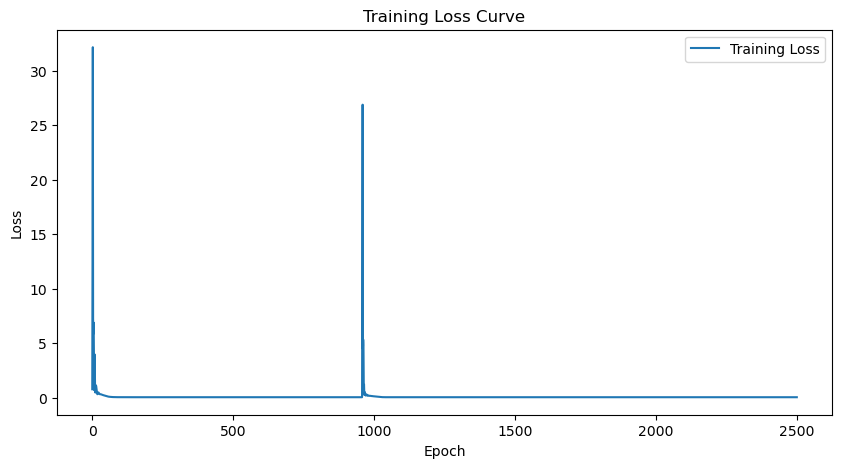

Best Model was saved at epoch 80 with F1-score 0.9296 and accuracy 91.53%


In [9]:
input_dim = X_train.shape[1]
hidden_dim = 256

custom_mlp, losses, best_accuracy, best_f1 = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [10]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_last_token.pth'.


In [ ]:
print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

Final Model Accuracy: 91.53%
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118



/tmp/ipykernel_2555485/3740627605.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()


: 